In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns


### Loading dataset

In [3]:
stock_market = pd.read_excel('./nvda-stockmarket.xlsx',engine='openpyxl')

In [4]:
stock_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Contract Name          353 non-null    object        
 1   Last Trade Date (EDT)  353 non-null    datetime64[ns]
 2   Strike                 353 non-null    float64       
 3   Last Price             353 non-null    float64       
 4   Bid                    353 non-null    float64       
 5   Ask                    353 non-null    float64       
 6   Change                 353 non-null    float64       
 7   % Change               353 non-null    float64       
 8   Volume                 353 non-null    object        
 9   Open Interest          353 non-null    int64         
 10  Implied Volatility     353 non-null    float64       
 11  Option Type            353 non-null    object        
dtypes: datetime64[ns](1), float64(7), int64(1), object(3)
memory usa

In [5]:
new_column_names = {
    '% Change': 'dChange',
    
}

stock_market.rename(columns=new_column_names, inplace=True)



In [6]:
#stock market date time to date time
stock_market['Date'] = stock_market['Last Trade Date (EDT)'].dt.date

In [7]:
stock_market['Time'] = stock_market['Last Trade Date (EDT)'].dt.time

In [8]:
stock_market.head()

,Contract Name,Last Trade Date (EDT),Strike,Last Price,Bid,Ask,Change,dChange,Volume,Open Interest,Implied Volatility,Option Type,Date,Time
0,NVDA240301C00250000,2024-02-27 20:31:00,250.0,540.03,533.55,535.4,0.0,0.0,9,31,6.1533,call,2024-02-27,20:31:00
1,NVDA240301C00260000,2024-02-26 20:59:00,260.0,531.66,523.95,525.4,0.0,0.0,3,12,6.0527,call,2024-02-26,20:59:00
2,NVDA240301C00270000,2024-02-26 20:13:00,270.0,523.00,513.55,515.4,0.0,0.0,28,16,5.7617,call,2024-02-26,20:13:00
3,NVDA240301C00280000,2024-02-22 18:03:00,280.0,495.19,504.00,505.8,0.0,0.0,1,16,5.7690,call,2024-02-22,18:03:00
4,NVDA240301C00290000,2024-02-26 20:02:00,290.0,500.59,494.15,495.7,0.0,0.0,30,2,5.5967,call,2024-02-26,20:02:00


In [9]:
stock_market = stock_market.drop(['Contract Name','Last Trade Date (EDT)'], axis = 1)

In [10]:
stock_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Strike              353 non-null    float64
 1   Last Price          353 non-null    float64
 2   Bid                 353 non-null    float64
 3   Ask                 353 non-null    float64
 4   Change              353 non-null    float64
 5   dChange             353 non-null    float64
 6   Volume              353 non-null    object 
 7   Open Interest       353 non-null    int64  
 8   Implied Volatility  353 non-null    float64
 9   Option Type         353 non-null    object 
 10  Date                353 non-null    object 
 11  Time                353 non-null    object 
dtypes: float64(7), int64(1), object(4)
memory usage: 33.2+ KB


In [14]:

# Assuming 'stock_market' is your DataFrame
# Check for missing values
missing_values = stock_market['Volume'].isnull().sum()
if missing_values > 0:
    print(f"There are {missing_values} missing values in the 'Volume' column. Please handle them before proceeding.")
else:
    # Convert to numeric
    stock_market['Volume'] = pd.to_numeric(stock_market['Volume'], errors='coerce')
    
    # Check for non-finite values
    non_finite_values = stock_market['Volume'].isna().sum()
    if non_finite_values > 0:
        print(f"There are {non_finite_values} non-finite values in the 'Volume' column after converting to numeric. Please investigate.")
    else:
        # Drop non-finite values
        stock_market.dropna(subset=['Volume'], inplace=True)
        
        # Convert to integer
        stock_market['Volume'] = stock_market['Volume'].astype(int)

# Print DataFrame information
stock_market.info()



There are 4 missing values in the 'Volume' column. Please handle them before proceeding.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Strike              353 non-null    float64
 1   Last Price          353 non-null    float64
 2   Bid                 353 non-null    float64
 3   Ask                 353 non-null    float64
 4   Change              353 non-null    float64
 5   dChange             353 non-null    float64
 6   Volume              349 non-null    float64
 7   Open Interest       353 non-null    int64  
 8   Implied Volatility  353 non-null    float64
 9   Option Type         353 non-null    object 
 10  Date                353 non-null    object 
 11  Time                353 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 33.2+ KB


There are 4-54 nAN values in volume, Let's get rid of these

In [15]:
stock_market['Volume'].isna().sum()

4

In [16]:
stock_market = stock_market.dropna()

In [17]:
stock_market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349 entries, 0 to 352
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Strike              349 non-null    float64
 1   Last Price          349 non-null    float64
 2   Bid                 349 non-null    float64
 3   Ask                 349 non-null    float64
 4   Change              349 non-null    float64
 5   dChange             349 non-null    float64
 6   Volume              349 non-null    float64
 7   Open Interest       349 non-null    int64  
 8   Implied Volatility  349 non-null    float64
 9   Option Type         349 non-null    object 
 10  Date                349 non-null    object 
 11  Time                349 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 35.4+ KB


In [63]:
stock_market  = stock_market.sort_values(by=['Date', 'Time'])

#stock_market = stock_market.sort_values(by = 'Time')

In [64]:
stock_market

,Strike,Last Price,Bid,Ask,Change,dChange,Volume,Open Interest,Implied Volatility,Option Type,Date,Time
20,395.0,227.38,392.65,395.05,0.00,0.0000,3.0,3,4.8450,call,2024-01-25,17:15:00
24,415.0,205.07,372.70,375.05,0.00,0.0000,1.0,1,4.5464,call,2024-01-25,17:20:00
8,330.0,282.75,457.60,459.90,0.00,0.0000,2.0,2,5.9258,call,2024-01-26,20:30:00
16,375.0,243.01,409.00,410.55,0.00,0.0000,1.0,1,4.2095,call,2024-01-29,17:20:00
339,1170.0,431.66,379.75,387.45,0.00,0.0000,20.0,0,1.6191,Puts,2024-02-14,20:58:00
...,...,...,...,...,...,...,...,...,...,...,...,...
256,665.0,0.06,0.05,0.07,-0.02,-0.2500,182.0,1762,0.6836,Puts,2024-02-28,17:28:00
284,765.0,3.60,3.30,3.45,-0.60,-0.1429,6715.0,3590,0.3528,Puts,2024-02-28,17:28:00
287,780.0,8.51,8.30,8.45,-0.54,-0.0597,14617.0,4488,0.3444,Puts,2024-02-28,17:28:00
118,840.0,0.56,0.55,0.57,-0.59,-0.5130,2746.0,5627,0.4517,call,2024-02-28,17:28:00


so the governing equation is dependent on V is the price of the option as a function of the underlying asset price S and time  t.


σ is the volatility of the underlying asset.


r is the risk-free interest rate.

# EDA 

### checking for NANs

In [65]:
print(f'Number of calls and Puts : {stock_market["Option Type"].value_counts()}')

Number of calls and Puts : call    180
Puts    169
Name: Option Type, dtype: int64


if buying a call then betting that it will go up
if put then will go down

/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


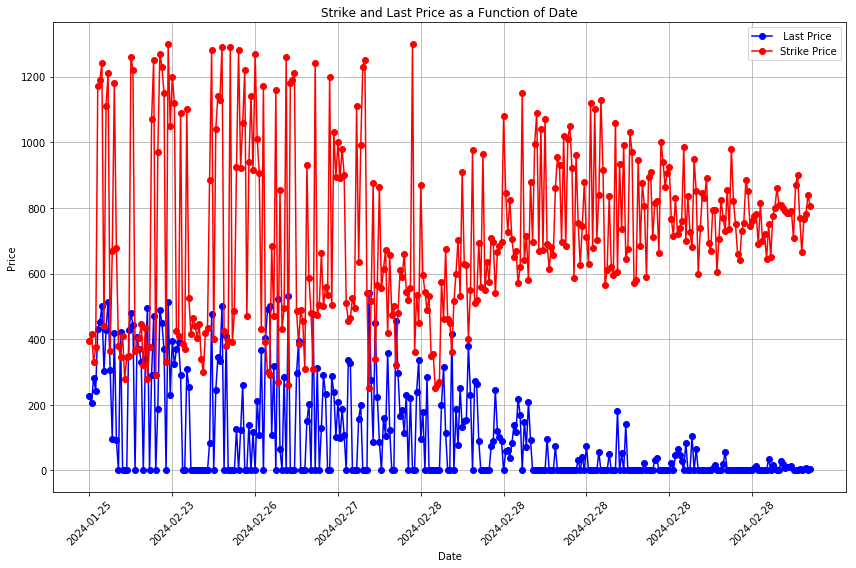

In [66]:
# Plot 'Volume' as a function of 'Date'
plt.figure(figsize=(12, 8))
plt.plot(range(stock_market.shape[0]), stock_market['Last Price'], color = 'blue', marker='o', linestyle='-', label = ' Last Price')
plt.plot(range(stock_market.shape[0]), stock_market['Strike'], color = 'red',marker='o', linestyle='-', label = 'Strike Price')

plt.xticks(range(0,stock_market.shape[0],40),stock_market['Date'].loc[::40],rotation=45)

plt.title('Strike and Last Price as a Function of Date')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

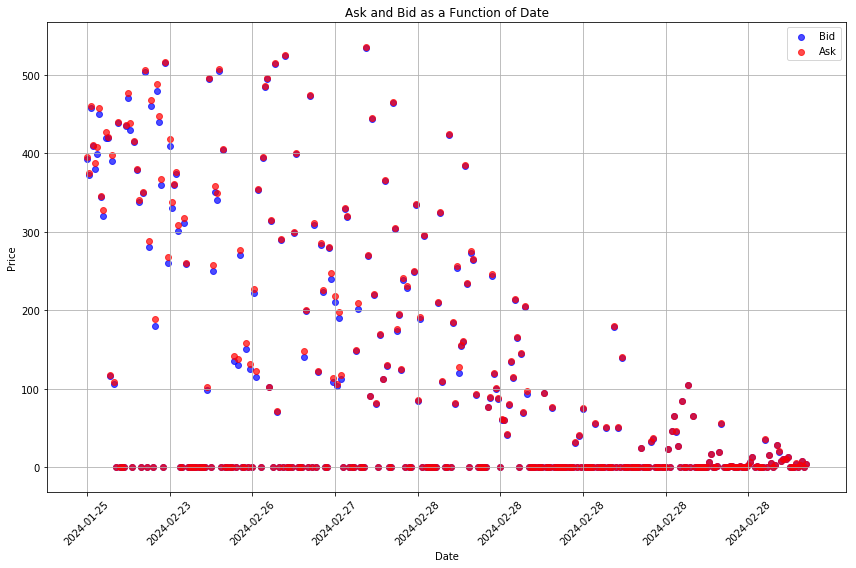

In [67]:
# Plot 'Volume' as a function of 'Date'
plt.figure(figsize=(12, 8))
plt.scatter(range(stock_market.shape[0]), stock_market['Bid'], alpha = 0.7, color = 'blue', marker='o', linestyle='-', label = 'Bid')
plt.scatter(range(stock_market.shape[0]), stock_market['Ask'], alpha = 0.7, color = 'red',marker='o', linestyle='-', label = 'Ask')

plt.xticks(range(0,stock_market.shape[0],40),stock_market['Date'].loc[::40],rotation=45)

plt.title('Ask and Bid as a Function of Date')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

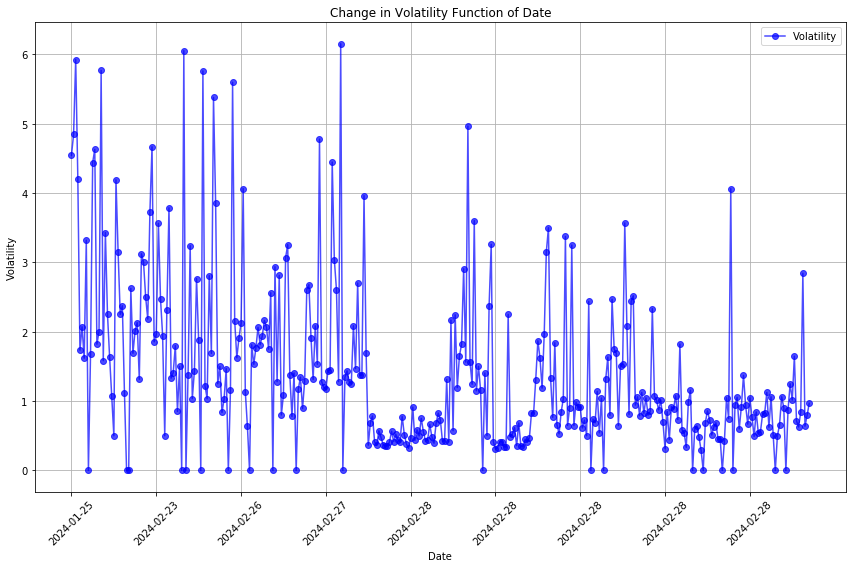

In [61]:
plt.figure(figsize=(12, 8))
plt.plot(range(stock_market.shape[0]), stock_market['Implied Volatility'], alpha = 0.7, color = 'blue', marker='o', linestyle='-', label = 'Volatility')

plt.xticks(range(0,stock_market.shape[0],40),stock_market['Date'].loc[::40],rotation=45)

plt.title('Change in Volatility Function of Date')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
from datetime import datetime

# Convert 'Option Type' to numerical labels
label_encoder = LabelEncoder()

stock_market['Option Type'] = label_encoder.fit_transform(stock_market['Option Type'])

# Separate features and target
y = stock_market['Option Type']
X = stock_market.drop('Option Type', axis = 1)


In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349 entries, 0 to 352
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Strike              349 non-null    float64
 1   Last Price          349 non-null    float64
 2   Bid                 349 non-null    float64
 3   Ask                 349 non-null    float64
 4   Change              349 non-null    float64
 5   dChange             349 non-null    float64
 6   Volume              349 non-null    float64
 7   Open Interest       349 non-null    int64  
 8   Implied Volatility  349 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 27.3 KB


In [16]:
X.shape, y.shape

((349, 9), (349,))

In [14]:
# Turninig Data to Tensor 
X = torch.from_numpy(X.values).type(torch.float)
y = torch.from_numpy(y.values).type(torch.float)

1. input layer shape = # of features
2. Output Layer shape = 1(one class or the other) for multiclassificatin = 3 
3. Hidden Layer Activation usually ReLu could use other too
4. Output activation Sigmoid, Softmax for multiclass
5. Loss Function Binary CrossEntropy
6. Optimizer = SGD, Adan

In [15]:
## Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [71]:
X_train.info()

AttributeError: 'Tensor' object has no attribute 'info'

In [62]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
# Define the neural network model
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=9, out_features=6) # takes in 11 features (X), produces 6 features
        self.layer_2 = nn.Linear(in_features=6, out_features=1) # takes in 6 features, produces 1 feature (y)
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = BinaryClassifier()
model_0


BinaryClassifier(
  (layer_1): Linear(in_features=9, out_features=6, bias=True)
  (layer_2): Linear(in_features=6, out_features=1, bias=True)
)

In [54]:
# Make predictions with the model
untrained_preds = model_0(X_test)
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 70, Shape: torch.Size([70, 1])
Length of test samples: 70, Shape: torch.Size([70])

First 10 predictions:
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


In [19]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=deep.parameters(), 
                            lr=0.001)

In [21]:
# Check for NaN values
has_nan = torch.isnan(X_train).any().item()
if has_nan:
    print("The tensor contains NaN values.")
else:
    print("The tensor does not contain NaN values.")


The tensor does not contain NaN values.


### Training and building 

In [30]:
import torch
import torch.nn as nn
from torch.optim import SGD

torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze()
    # Squeeze to remove extra `1` dimensions; this won't work unless model and data are on the same device 
    y_pred = torch.round(torch.sigmoid(y_logits))  # Turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.no_grad():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
    
    # Print out what's happening every epoch
    print(f"Epoch: {epoch} | Loss: {loss.item():.5f} | Test loss: {test_loss.item():.5f}")

     # Print intermediate values for debugging
    #print("y_pred:", y_pred)
    #print("y_logits:", y_logits)
    #print("test_pred:", test_pred)
    #print("test_logits:", test_logits)

    # Check for NaN or infinite values in tensors
    if torch.isnan(loss) or torch.isinf(loss):
        print("Training loss is NaN or infinite. Exiting training loop.")
        break


Epoch: 0 | Loss: 143.59129 | Test loss: 341.18546
Epoch: 1 | Loss: 242.75963 | Test loss: 29.29285
Epoch: 2 | Loss: 19.02667 | Test loss: 18.66355
Epoch: 3 | Loss: 13.87927 | Test loss: 57.40464
Epoch: 4 | Loss: 35.56451 | Test loss: 11.54196
Epoch: 5 | Loss: 6.53236 | Test loss: 28.11400
Epoch: 6 | Loss: 19.98043 | Test loss: 27.34684
Epoch: 7 | Loss: 17.10603 | Test loss: 2.74864
Epoch: 8 | Loss: 2.06041 | Test loss: 18.74428
Epoch: 9 | Loss: 11.44220 | Test loss: 11.97199
Epoch: 10 | Loss: 7.33447 | Test loss: 2.18331
Epoch: 11 | Loss: 1.85456 | Test loss: 11.59234
Epoch: 12 | Loss: 7.02199 | Test loss: 4.17031
Epoch: 13 | Loss: 2.74874 | Test loss: 15.72265
Epoch: 14 | Loss: 13.79070 | Test loss: 13.57867
Epoch: 15 | Loss: 9.61518 | Test loss: 1.98614
Epoch: 16 | Loss: 2.04755 | Test loss: 13.15585
Epoch: 17 | Loss: 9.90176 | Test loss: 1.32624
Epoch: 18 | Loss: 1.16874 | Test loss: 7.48221
Epoch: 19 | Loss: 6.72798 | Test loss: 7.49547
Epoch: 20 | Loss: 5.62586 | Test loss: 1.6965

Epoch: 21 | Loss: 1.50288 | Test loss: 6.06568
Epoch: 22 | Loss: 4.31421 | Test loss: 3.06850
Epoch: 23 | Loss: 2.46807 | Test loss: 4.21129
Epoch: 24 | Loss: 3.54466 | Test loss: 3.75095
Epoch: 25 | Loss: 3.18610 | Test loss: 5.43813
Epoch: 26 | Loss: 4.43060 | Test loss: 1.05594
Epoch: 27 | Loss: 1.01376 | Test loss: 1.16590
Epoch: 28 | Loss: 0.98542 | Test loss: 1.51749
Epoch: 29 | Loss: 1.10727 | Test loss: 1.46089
Epoch: 30 | Loss: 1.48498 | Test loss: 2.48416
Epoch: 31 | Loss: 2.37024 | Test loss: 4.04444
Epoch: 32 | Loss: 3.27785 | Test loss: 0.72790
Epoch: 33 | Loss: 0.80031 | Test loss: 2.22055
Epoch: 34 | Loss: 1.75533 | Test loss: 1.56449
Epoch: 35 | Loss: 1.58086 | Test loss: 3.21894
Epoch: 36 | Loss: 2.65339 | Test loss: 0.94416
Epoch: 37 | Loss: 0.86329 | Test loss: 1.32623
Epoch: 38 | Loss: 1.26197 | Test loss: 2.19965
Epoch: 39 | Loss: 1.94935 | Test loss: 0.75794
Epoch: 40 | Loss: 0.75120 | Test loss: 0.99759
Epoch: 41 | Loss: 0.95803 | Test loss: 1.65659
Epoch: 42 | L

changing the model and making it denser
2. Plot the losses and. 

In [17]:


class DeeperBinaryClassifier(nn.Module):
    def __init__(self):
        super(DeeperBinaryClassifier, self).__init__()
        self.layer_1 = nn.Linear(in_features=9, out_features=12)
        self.layer_2 = nn.Linear(in_features=12, out_features=8)
        self.layer_3 = nn.Linear(in_features=8, out_features=4)
        self.layer_4 = nn.Linear(in_features=4, out_features=1)

    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        x = self.layer_4(x)
        return x

In [21]:
model = DeeperBinaryClassifier()

Epoch: 0 | Loss: 1.15516 | Test loss: 0.68678
Epoch: 1 | Loss: 0.69333 | Test loss: 0.68678
Epoch: 2 | Loss: 0.69402 | Test loss: 0.68678
Epoch: 3 | Loss: 0.69365 | Test loss: 0.68678
Epoch: 4 | Loss: 0.69385 | Test loss: 0.68679
Epoch: 5 | Loss: 0.69363 | Test loss: 0.68679
Epoch: 6 | Loss: 0.69379 | Test loss: 0.68679
Epoch: 7 | Loss: 0.69359 | Test loss: 0.68679
Epoch: 8 | Loss: 0.69373 | Test loss: 0.68679
Epoch: 9 | Loss: 0.69354 | Test loss: 0.68679
Epoch: 10 | Loss: 0.69368 | Test loss: 0.68679
Epoch: 11 | Loss: 0.69350 | Test loss: 0.68679
Epoch: 12 | Loss: 0.69363 | Test loss: 0.68679
Epoch: 13 | Loss: 0.69347 | Test loss: 0.68680
Epoch: 14 | Loss: 0.69357 | Test loss: 0.68680
Epoch: 15 | Loss: 0.69343 | Test loss: 0.68680
Epoch: 16 | Loss: 0.69352 | Test loss: 0.68680
Epoch: 17 | Loss: 0.69339 | Test loss: 0.68680
Epoch: 18 | Loss: 0.69347 | Test loss: 0.68680
Epoch: 19 | Loss: 0.69335 | Test loss: 0.68680
Epoch: 20 | Loss: 0.69342 | Test loss: 0.68680
Epoch: 21 | Loss: 0.693

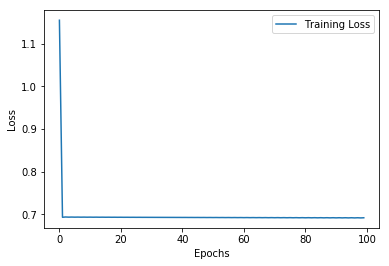

In [20]:
epochs = 100

# Lists to store training loss for plotting
train_loss_history = []

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    deep.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = deep(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))  # Turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()

    ### Testing
    deep.eval()
    with torch.no_grad():
        # 1. Forward pass
        test_logits = deep(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
    
    # Print out what's happening every epoch
    print(f"Epoch: {epoch} | Loss: {loss.item():.5f} | Test loss: {test_loss.item():.5f}")

    # Append training loss to the list for plotting
    train_loss_history.append(loss.item())

    # Check for NaN or infinite values in tensors
    if torch.isnan(loss) or torch.isinf(loss):
        print("Training loss is NaN or infinite. Exiting training loop.")
        break

# Plot training loss over epochs
plt.plot(range(epochs), train_loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the number of epochs
epochs = 100

# Training loop
for epoch in range(epochs):
    model.train()
    
    # 1. Forward pass (model outputs raw logits)
    y_logits = model(X_train).squeeze()
    # Squeeze to remove extra `1` dimensions; this won't work unless model and data are on the same device 
    y_pred = torch.round(torch.sigmoid(y_logits))  # Turn logits -> pred probs -> pred labels

    loss = criterion(y_logits, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss for every few epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate on test data
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)

print(f'Test Loss: {test_loss.item():.4f}')


Epoch [10/100], Loss: 743.2023
Epoch [20/100], Loss: 740.9802
Epoch [30/100], Loss: 740.6160


Epoch [40/100], Loss: 740.2402
Epoch [50/100], Loss: 739.9799
Epoch [60/100], Loss: 739.7703
Epoch [70/100], Loss: 739.5802
Epoch [80/100], Loss: 739.3683
Epoch [90/100], Loss: 739.2172
Epoch [100/100], Loss: 739.0782


RuntimeError: expected scalar type Long but found Float

The differential equation related to the black scholes model is : 
$
    \frac{\delV}{a}
$

In [ ]:
S : Stock Price /  Spot price
K : Strike Price
r : interest rate
sigma : implied volatility

In [1]:
import pandas as pd
df = pd.read_csv("/home/rhythm/Downloads/TSLA.csv")
df = df.sort_values(by="Date")
df = df.dropna()


/home/rhythm/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-03-29,193.130005,195.289993,189.440002,193.880005,193.880005,123660000
1,2023-03-30,195.580002,197.330002,194.419998,195.279999,195.279999,110252200
2,2023-03-31,197.529999,207.789993,197.199997,207.460007,207.460007,170222100
3,2023-04-03,199.910004,202.690002,192.199997,194.770004,194.770004,169545900
4,2023-04-04,197.320007,198.740005,190.320007,192.580002,192.580002,126463800


In [3]:
# calculate returns
df = df.assign(close_day_before=df.Close.shift(1))

In [4]:
df['returns'] = ((df.Close - df.close_day_before)/df.close_day_before)



In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,close_day_before,returns
0,2023-03-29,193.130005,195.289993,189.440002,193.880005,193.880005,123660000,NaN,NaN
1,2023-03-30,195.580002,197.330002,194.419998,195.279999,195.279999,110252200,193.880005,0.007221
2,2023-03-31,197.529999,207.789993,197.199997,207.460007,207.460007,170222100,195.279999,0.062372
3,2023-04-03,199.910004,202.690002,192.199997,194.770004,194.770004,169545900,207.460007,-0.061168
4,2023-04-04,197.320007,198.740005,190.320007,192.580002,192.580002,126463800,194.770004,-0.011244


In [13]:
pip install beautifulsoup4



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
from bs4 import BeautifulSoup
import requests
import pandas as pd


In [15]:
url = "https://finance.yahoo.com/quote/TSLA/options"
response = requests.get(url)


In [16]:
soup = BeautifulSoup(response.text, 'html.parser')


In [17]:
table = soup.find('table', class_='calls')


In [26]:
pip install requests



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
import requests

url = 'https://finance.yahoo.com/quote/TSLA/options'

In [32]:
response = requests.get(url)



In [37]:
print(response.status_code)


404


In [35]:
import json
try:
    data = response.json()
#except json.decoder.JSONDecodeError as e:
#    print("Error decoding JSON:", e)
#    print("Response content:", response.text)


SyntaxError: unexpected EOF while parsing (<ipython-input-35-e9e037596af3>, line 6)

the black-scholes modes can estimate the value of "s".  which takes in S :spot price at the moment, for call one can compare the "ask". This would also depend on the volume. [if it has been traded or not]

# Notes

## RNN

RNN are not feed forward neural network. recognize patterns in sequences of data, such as time series or text. 
Found this link that builds up basic lstm model: https://colab.research.google.com/drive/1CBIdPxHn_W2ARx4VozRLIptBrXk7ZBoM?usp=sharing#scrollTo=1jgb1aJ3lxlQ  / https://www.youtube.com/watch?v=q_HS4s1L8UI

## Black scholes model

We have black scholes model that can help us predict the call or put options' price. 
The black scholes model is governed by the differential equation :  

$\begin{equation}
    \frac{\partial C}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 C}{\partial S^2} + rS \frac{\partial C}{\partial S} - rC = 0
\end{equation}    $


where C is the call option price, 
<br> S : Stock price, 
<br> t : at time 't'
<br> r : risk free interest
<br> C : 
<br> $\sigma$ : volatility
<br> C(T,s) : K(s)

we could also use the black scoles model equation too or it can be solved to 


$\begin{equation}
    C = S_0 N(d_1)- K e^{-rT} N(d_2)
\end{equation}    $


where $N(d_1)$ is the cumulative distribution and, is equal to 


$ \begin{equation}
    d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)T}{\sigma \sqrt{T}}
\end{equation}
$

$ \begin{equation}
    d_2 = d_1 - \sigma \sqrt{T}
\end{equation}
$

$K$ is the strike price , 
$T$ is the time to maturity, $S_0$ is the stock price

he equation takes into account various factors, such as the current stock price, the option's strike price, the time until expiration, the risk-free interest rate, and the stock's volatility. By plugging in these variables, the equation calculates the theoretical price of the option, which represents the fair value of the option in a perfectly efficient market.

"

We will use this to constrain the loss from PINN
<br>and, also use features to learn from neural network

using yfinance

In [ ]:
pip install yfinance


In [1]:
import yfinance as yf

# Define the ticker symbol of the stock you're interested in
ticker_symbol = 'NVDA'

# Fetch historical stock data


/home/rhythm/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
stock_data = yf.download(ticker_symbol, start='2023-01-01', end='2024-04-05')



[*********************100%%**********************]  1 of 1 completed


In [5]:
print("Historical Stock Data:")
#print(stock_data.head())
# Convert historical stock data to DataFrame
stock_df = pd.DataFrame(stock_data)
stock_df.head()

Historical Stock Data:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,148.509995,149.960007,140.960007,143.149994,143.079773,40127700
2023-01-04,145.669998,148.529999,142.410004,147.490005,147.417679,43132400
2023-01-05,144.910004,145.639999,141.479996,142.649994,142.580048,38916800
2023-01-06,144.740005,150.100006,140.339996,148.589996,148.517120,40504400
2023-01-09,152.839996,160.559998,151.410004,156.279999,156.203354,50423100


In [10]:
stock_df = stock_df.sort_values(by='Date')

# Display the sorted DataFrame
stock_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-28,900.000000,913.000000,891.929993,903.559998,903.559998,43521200
2024-04-01,902.989990,922.250000,892.039978,903.630005,903.630005,45244100
2024-04-02,884.479980,900.940002,876.200012,894.520020,894.520020,43306400
2024-04-03,884.840027,903.739990,884.000000,889.640015,889.640015,37006700
2024-04-04,904.059998,906.340027,858.799988,859.049988,859.049988,43496500


In [52]:
stock_df.reset_index(inplace=True)
stock_df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-03,148.509995,149.960007,140.960007,143.149994,143.079773,40127700
1,2023-01-04,145.669998,148.529999,142.410004,147.490005,147.417679,43132400
2,2023-01-05,144.910004,145.639999,141.479996,142.649994,142.580048,38916800
3,2023-01-06,144.740005,150.100006,140.339996,148.589996,148.517120,40504400
4,2023-01-09,152.839996,160.559998,151.410004,156.279999,156.203369,50423100


In [33]:
#let us look at what the stock_data for nvda is showing 
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315 entries, 2023-01-03 to 2024-04-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       315 non-null    float64
 1   High       315 non-null    float64
 2   Low        315 non-null    float64
 3   Close      315 non-null    float64
 4   Adj Close  315 non-null    float64
 5   Volume     315 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 17.2 KB


In [34]:
stock_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,315.000000,315.000000,315.000000,315.000000,315.000000,3.150000e+02
mean,441.159714,448.827936,433.644697,441.850857,441.782295,4.856292e+07
std,189.900611,193.201279,185.600201,189.285360,189.310871,1.598912e+07
min,144.740005,145.639999,140.339996,142.649994,142.580048,1.982090e+07
25%,276.610001,280.000000,272.735001,277.629990,277.540970,3.883590e+07
50%,438.269989,441.440002,430.010010,437.529999,437.434998,4.511530e+07
75%,490.059998,495.360001,481.310013,488.069992,488.005554,5.415520e+07
max,958.510010,974.000000,935.099976,950.020020,950.020020,1.543911e+08


In [35]:
#check for duplicated 
stock_df.duplicated().sum()
stock_df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, Non

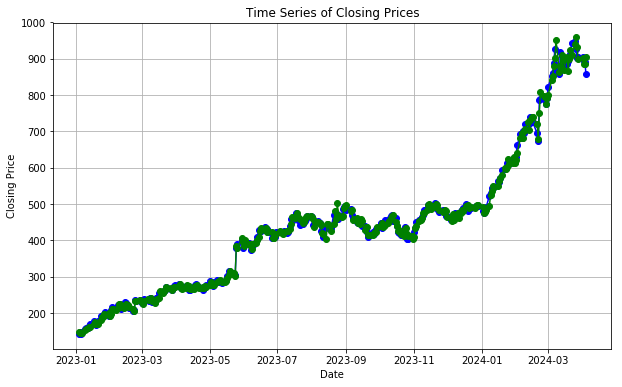

In [36]:
import matplotlib.pyplot as plt

# Plotting the time series of closing prices
plt.figure(figsize=(10, 6))
plt.plot(stock_df.index, stock_df['Close'], color='blue', marker='o', linestyle='-')
plt.plot(stock_df.index, stock_df['Open'], color='green', marker='o', linestyle='-')

# Adding title and labels
plt.title('Time Series of Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')

# Displaying the plot
plt.grid(True)
plt.show()


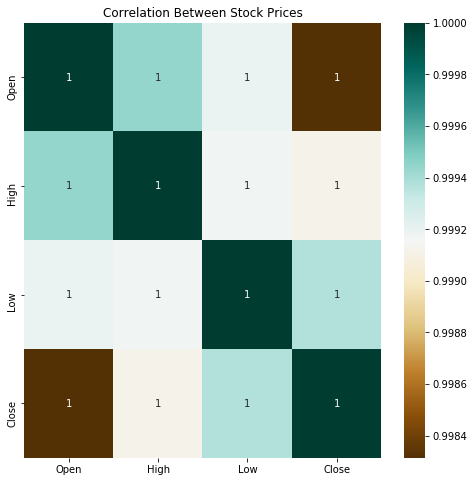

In [37]:
# Create a heatmap of the correlation between stock prices
corr = stock_df[['Open', 'High', 'Low', 'Close']].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cmap='BrBG')
plt.title('Correlation Between Stock Prices')
plt.show()

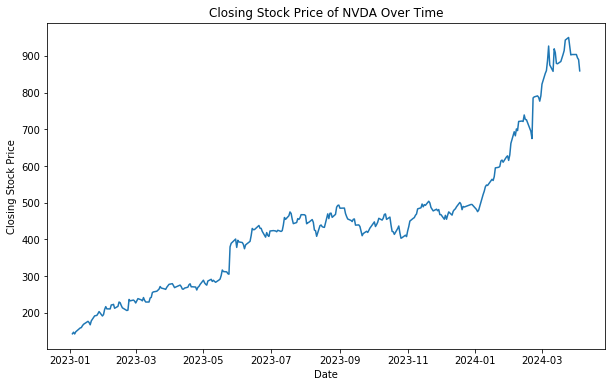

In [38]:

# Line chart of closing stock price for a specific company over time

plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Close', data=stock_df)
plt.title(f'Closing Stock Price of NVDA Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Stock Price')
plt.show()

/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `

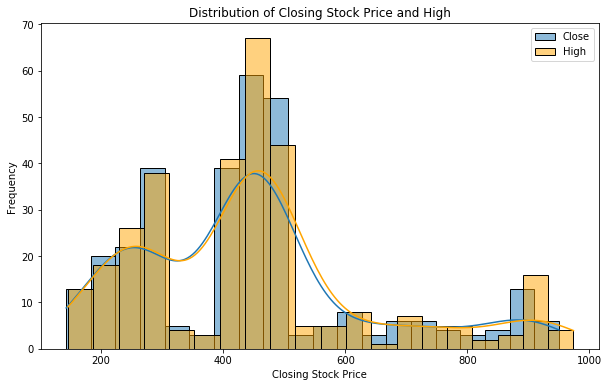

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(stock_df['Close'], kde=True, bins = 20, label = 'Close')
sns.histplot(stock_df['High'], kde=True, bins = 20, color= 'orange', label = 'High')

plt.title('Distribution of Closing Stock Price and High' )
plt.xlabel('Closing Stock Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [6]:
# Fetch options data
options_data = yf.Ticker(ticker_symbol).options


In [8]:
# Print the available options expiration dates
print("\nOptions Expiration Dates:")
print(options_data)


Options Expiration Dates:
('2024-04-12', '2024-04-19', '2024-04-26', '2024-05-03', '2024-05-10', '2024-05-17', '2024-05-24', '2024-06-21', '2024-07-19', '2024-08-16', '2024-09-20', '2024-10-18', '2024-11-15', '2024-12-20', '2025-01-17', '2025-02-21', '2025-03-21', '2025-06-20', '2025-12-19', '2026-01-16', '2026-06-18', '2026-12-18')


In [7]:
# Fetch options chain for a specific expiration date
expiration_date = options_data[7]
print(expiration_date) 
options_chain = yf.Ticker(ticker_symbol).option_chain(expiration_date)


2024-06-21


In [8]:
# Convert options chain data to DataFrames
calls_df = pd.DataFrame(options_chain.calls)
puts_df = pd.DataFrame(options_chain.puts)


In [11]:
calls_df.head()


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,NVDA240621C00005000,2024-04-11 14:45:26+00:00,5.0,880.65,875.10,878.95,0.0,0.0,12,4962,4.683598,True,REGULAR,USD
1,NVDA240621C00010000,2024-04-05 15:43:56+00:00,10.0,869.40,870.05,874.25,0.0,0.0,2,98,4.183599,True,REGULAR,USD
2,NVDA240621C00015000,2024-04-11 13:36:26+00:00,15.0,869.61,865.05,869.30,0.0,0.0,2,35,3.765626,True,REGULAR,USD
3,NVDA240621C00020000,2024-03-15 13:37:59+00:00,20.0,848.00,860.15,863.95,0.0,0.0,1,148,3.261721,True,REGULAR,USD
4,NVDA240621C00025000,2024-02-16 15:55:43+00:00,25.0,708.61,851.90,856.05,0.0,0.0,4,82,0.000010,True,REGULAR,USD


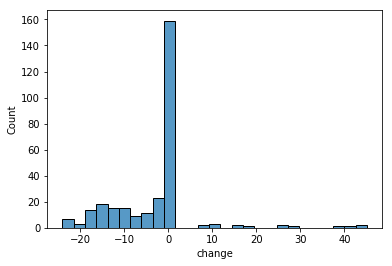

In [12]:
sns.histplot(calls_df['change'])

In [12]:
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   contractSymbol     289 non-null    object             
 1   lastTradeDate      289 non-null    datetime64[ns, UTC]
 2   strike             289 non-null    float64            
 3   lastPrice          289 non-null    float64            
 4   bid                289 non-null    float64            
 5   ask                289 non-null    float64            
 6   change             289 non-null    float64            
 7   percentChange      289 non-null    float64            
 8   volume             289 non-null    int64              
 9   openInterest       289 non-null    int64              
 10  impliedVolatility  289 non-null    float64            
 11  inTheMoney         289 non-null    bool               
 12  contractSize       289 non-null    object         

In [13]:
calls_df  = calls_df.drop(['contracmerged_dftSymbol'], axis =1 )

In [14]:
calls_df.describe()

,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility
count,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000
mean,804.152249,276.348651,273.565225,276.179066,-0.524567,-2.059324,60.546713,1323.910035,0.863517
std,535.527768,273.896387,270.452271,272.222035,10.594472,11.038450,204.293087,3250.478596,0.584849
min,5.000000,0.620000,0.590000,0.630000,-95.250000,-82.255646,1.000000,10.000000,0.000000
25%,365.000000,16.300000,16.550000,16.950000,-0.160000,-1.858386,2.000000,267.000000,0.557133
50%,725.000000,180.940000,182.100000,184.200000,0.000000,0.000000,5.000000,634.000000,0.628910
75%,1170.000000,493.920000,493.550000,497.100000,1.479999,2.686782,25.000000,1198.000000,0.990662
max,1940.000000,878.300000,889.250000,895.800000,18.980042,9.908141,1879.000000,42127.000000,4.046880


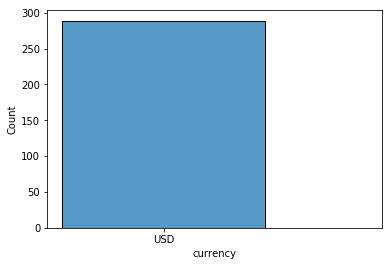

In [15]:
# let us see what is in the currecy and contract size and if it could be removed. 
sns.histplot(calls_df['currency'])

we see it is all in usd and can remove it. Let us look at now contract_size

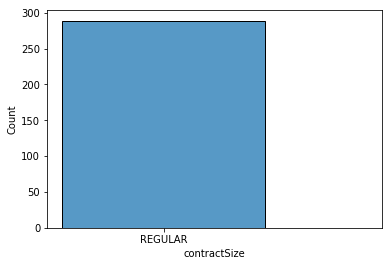

In [16]:
sns.histplot(calls_df['contractSize'])

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


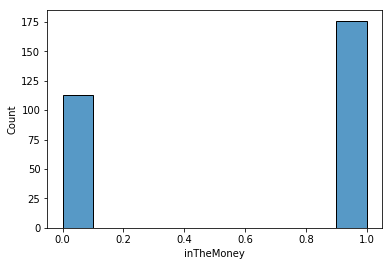

In [17]:
sns.histplot(calls_df['inTheMoney'])

From the above histogram distribution we could remove contractsize and currency. We will change the type of inThe money if needed be . 

In [18]:
calls_df  = calls_df.drop(['currency','contractSize' ], axis =1 )

/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rhythm/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


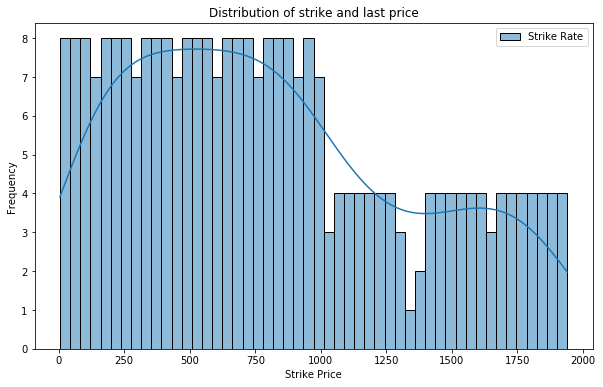

In [48]:
plt.figure(figsize=(10, 6))
sns.histplot(calls_df['strike'], kde=True, bins = 50, label = 'Strike Rate')
#sns.histplot(calls_df['lastPrice'], kde=True, bins = 20, color= 'orange', label = 'Last Price')

plt.title('Distribution of strike and last price' )
plt.xlabel('Strike Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [21]:
calls_df.head()

,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney
0,2024-04-05 15:28:57+00:00,5.0,869.75,873.70,876.60,-11.419983,-1.296002,1,4967,4.046880,True
1,2024-04-05 15:17:19+00:00,10.0,869.40,868.70,871.60,-5.599976,-0.639997,2,96,3.406251,True
2,2024-03-12 14:35:45+00:00,15.0,878.19,863.75,866.70,0.000000,0.000000,3,35,3.285158,True
3,2024-03-15 13:37:59+00:00,20.0,848.00,858.85,862.25,0.000000,0.000000,1,148,3.460939,True
4,2024-02-16 15:55:43+00:00,25.0,708.61,851.90,856.05,0.000000,0.000000,4,82,3.562501,True


In [24]:
# converting the date-time format
# Let's assume your datetime column is named 'lastTradeDate'
calls_df['lastTradeDate'] = pd.to_datetime(calls_df['lastTradeDate'])

# Extracting date and time into separate columns
calls_df['Date'] = calls_df['lastTradeDate'].dt.date
calls_df['Time'] = calls_df['lastTradeDate'].dt.time

# If you want to separate date into year, month, and day columns:
calls_df['Year']  = calls_df['lastTradeDate'].dt.year
calls_df['Month'] = calls_df['lastTradeDate'].dt.month
calls_df['Day']   = calls_df['lastTradeDate'].dt.day

In [26]:
calls_df = calls_df.drop(['lastTradeDate'], axis = 1)

In [28]:
calls_df = calls_df.sort_values(by='Date')
calls_df

,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,Date,Time,Year,Month,Day
7,40.0,251.00,336.00,345.50,0.00,0.000000,1,10,0.000010,True,2023-05-01,17:34:22,2023,5,1
8,45.0,408.55,413.00,422.90,0.00,0.000000,2,138,0.000010,True,2023-07-26,15:46:19,2023,7,26
20,105.0,357.75,349.50,359.00,0.00,0.000000,2,649,0.000010,True,2023-09-13,17:09:14,2023,9,13
10,55.0,382.67,365.00,372.70,0.00,0.000000,40,139,0.000010,True,2023-09-19,14:08:15,2023,9,19
13,70.0,432.73,420.05,424.10,0.00,0.000000,249,560,0.000010,True,2023-11-21,20:05:07,2023,11,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,1420.0,4.50,4.40,4.65,-0.90,-16.666668,145,286,0.586247,False,2024-04-05,19:47:27,2024,4,5
237,1430.0,4.55,4.20,4.45,-1.20,-20.869562,147,387,0.588017,False,2024-04-05,17:26:21,2024,4,5
238,1440.0,4.15,4.00,4.25,-0.85,-16.999998,1,141,0.589543,False,2024-04-05,14:40:50,2024,4,5
241,1470.0,3.57,3.50,3.75,-0.33,-8.461542,3,304,0.595158,False,2024-04-05,19:30:38,2024,4,5


so we have some data some from the stocks_df and calls_df for similar dates but, calls_df would also have for time

In [53]:
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-03,148.509995,149.960007,140.960007,143.149994,143.079773,40127700
1,2023-01-04,145.669998,148.529999,142.410004,147.490005,147.417679,43132400
2,2023-01-05,144.910004,145.639999,141.479996,142.649994,142.580048,38916800
3,2023-01-06,144.740005,150.100006,140.339996,148.589996,148.517120,40504400
4,2023-01-09,152.839996,160.559998,151.410004,156.279999,156.203369,50423100


In [60]:
# Convert 'Date' column in calls_df to datetime64[ns]
calls_df['Date'] = pd.to_datetime(calls_df['Date'])

# Now you can merge the DataFrames
merged_df = pd.merge(stock_df, calls_df, on='Date', how='inner')


In [61]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126 entries, 0 to 125
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               126 non-null    datetime64[ns]
 1   Open               126 non-null    float64       
 2   High               126 non-null    float64       
 3   Low                126 non-null    float64       
 4   Close              126 non-null    float64       
 5   Adj Close          126 non-null    float64       
 6   Volume             126 non-null    int64         
 7   strike             126 non-null    float64       
 8   lastPrice          126 non-null    float64       
 9   bid                126 non-null    float64       
 10  ask                126 non-null    float64       
 11  change             126 non-null    float64       
 12  percentChange      126 non-null    float64       
 13  volume             126 non-null    int64         
 14  openIntere

There are 572 dates when combined of which only 289 are common. let us just keep those dates.

In [58]:
merged_df = merged_df.dropna()

In [62]:
merged_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,strike,lastPrice,bid,...,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,Time,Year,Month,Day
0,2023-05-01,278.399994,290.579987,277.799988,289.100006,289.007324,57032900,40.0,251.00,336.00,...,0.0,0.0,1,10,0.00001,True,17:34:22,2023,5,1
1,2023-07-26,460.209991,460.529999,446.299988,454.519989,454.421265,36423700,45.0,408.55,413.00,...,0.0,0.0,2,138,0.00001,True,15:46:19,2023,7,26
2,2023-09-13,446.000000,459.299988,445.029999,454.850006,454.788696,39835500,105.0,357.75,349.50,...,0.0,0.0,2,649,0.00001,True,17:09:14,2023,9,13
3,2023-09-19,438.329987,439.660004,430.019989,435.200012,435.141327,37306400,55.0,382.67,365.00,...,0.0,0.0,40,139,0.00001,True,14:08:15,2023,9,19
4,2023-11-21,501.260010,505.170013,492.220001,499.440002,499.372650,56574700,70.0,432.73,420.05,...,0.0,0.0,249,560,0.00001,True,20:05:07,2023,11,21


In [63]:
merged_df.describe()

,Open,High,Low,Close,Adj Close,Volume,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,Year,Month,Day
count,126.000000,126.000000,126.000000,126.000000,126.000000,1.260000e+02,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,870.499679,883.141990,847.588169,858.611270,858.606821,4.800225e+07,530.357143,456.187698,449.844841,453.798968,0.069525,-0.892204,7.555556,762.563492,1.088706,2023.960317,3.730159,9.706349
std,111.229744,111.990486,107.097538,107.608810,107.623947,1.047785e+07,518.131326,263.938556,259.975678,261.424108,2.301695,7.690154,26.200017,759.037754,0.693068,0.195992,1.182626,9.296939
min,278.399994,290.579987,277.799988,289.100006,289.007324,3.642370e+07,15.000000,0.920000,0.670000,0.850000,-15.929993,-80.310880,1.000000,10.000000,0.000000,2023.000000,1.000000,1.000000
25%,884.479980,903.739990,858.799988,859.049988,859.049988,4.330640e+07,176.250000,280.612500,287.675000,291.200000,0.000000,0.000000,1.000000,236.500000,0.639347,2024.000000,3.000000,3.000000
50%,902.989990,906.340027,870.574982,889.640015,889.640015,4.349650e+07,367.500000,490.510000,491.075000,494.350000,0.000000,0.000000,2.000000,620.000000,0.931794,2024.000000,4.000000,4.000000
75%,904.059998,913.000000,884.000000,902.500000,902.500000,5.496278e+07,602.500000,681.122500,654.262500,658.275000,0.000000,0.000000,5.000000,895.250000,1.420779,2024.000000,4.000000,19.000000
max,958.510010,974.000000,935.099976,950.020020,950.020020,1.132996e+08,1880.000000,878.300000,889.250000,895.800000,15.050018,8.413356,249.000000,4574.000000,3.562501,2024.000000,11.000000,28.000000


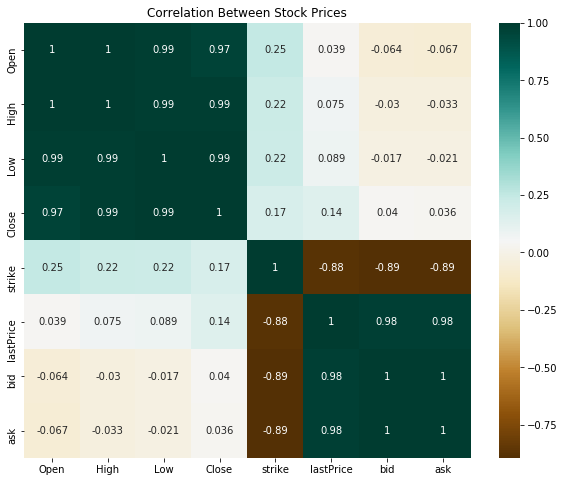

In [65]:
# Create a heatmap of the correlation between stock prices
corr = merged_df[['Open', 'High', 'Low', 'Close', 'strike', 'lastPrice', 'bid', 'ask']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='BrBG')
plt.title('Correlation Between Stock Prices')
plt.show()

Let's make a black-scholes model. and see what is happening 


In [14]:
import numpy as np
from scipy.stats import norm #importing the normal distribution function only 
import matplotlib.pyplot as plt

In [15]:
N = norm.cdf #defining a normal distribution 

In [13]:
#call price function, sigma=volatility(σ)
def BSM_call_price(S, K , T , r , sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T)) 
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T) * N(d2) 

#put price function, sigma = volatility(σ)
def BSM_put_price(S, K , T , r , sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T) * N(-d2) - S * N(-d1)


In [20]:
nvda = yf.download('NVDA', start= '2024-01-01', end='2024-04-03')
nvda = pd.DataFrame(nvda)
nvda['pct_change'] = nvda.Close.pct_change()
nvda['log_return'] = np.log(1 + nvda['pct_change'])
std = nvda['log_return'].std()
annualized_sigma = std * np.sqrt(252)


[*********************100%%**********************]  1 of 1 completed


In [38]:
nvda.tail()

,Open,High,Low,Close,Adj Close,Volume,pct_change,log_return
Date,,,,,,,,
2024-03-26,958.510010,963.750000,925.020020,925.609985,925.609985,51364800,-0.025694,-0.026030
2024-03-27,931.119995,932.400024,891.229980,902.500000,902.500000,58606700,-0.024967,-0.025284
2024-03-28,900.000000,913.000000,891.929993,903.559998,903.559998,43521200,0.001175,0.001174
2024-04-01,902.989990,922.250000,892.039978,903.630005,903.630005,45244100,0.000077,0.000077
2024-04-02,884.479980,900.940002,876.200012,894.520020,894.520020,43306400,-0.010082,-0.010133


In [40]:

#returns 0.2474...
# Fetch options data
options_data = yf.Ticker('NVDA').options

#nvda.options
option = yf.Ticker('NVDA').option_chain('2024-06-21')
calls = option.calls
list_calls = []


In [29]:
calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,NVDA240621C00005000,2024-04-11 14:45:26+00:00,5.0,880.65,875.10,878.95,0.0,0.0,12,4962,4.718754,True,REGULAR,USD
1,NVDA240621C00010000,2024-04-05 15:43:56+00:00,10.0,869.40,870.05,874.25,0.0,0.0,2,98,4.214848,True,REGULAR,USD
2,NVDA240621C00015000,2024-04-11 13:36:26+00:00,15.0,869.61,865.05,869.30,0.0,0.0,2,35,3.792969,True,REGULAR,USD
3,NVDA240621C00020000,2024-03-15 13:37:59+00:00,20.0,848.00,860.15,863.95,0.0,0.0,1,148,3.285158,True,REGULAR,USD
4,NVDA240621C00025000,2024-02-16 15:55:43+00:00,25.0,708.61,851.90,856.05,0.0,0.0,4,82,0.000010,True,REGULAR,USD


In [41]:

for i in calls['strike']:
    
   price = round(BSM_call_price(S = 884, 
   K = i, 
   T = (46/252), r = 0.0350, 
   sigma = annualized_sigma),2)
   
   list_calls.append(price)

calls['BSM_prices'] = list_calls



In [36]:
calls.tail()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,BSM_prices
284,NVDA240621C01900000,2024-04-12 18:06:54+00:00,1900.0,0.58,0.50,0.60,-0.07,-10.769230,10,848,0.678470,False,REGULAR,USD,0.0
285,NVDA240621C01910000,2024-04-11 18:54:37+00:00,1910.0,0.57,0.47,0.60,0.00,0.000000,5,124,0.680423,False,REGULAR,USD,0.0
286,NVDA240621C01920000,2024-04-11 19:45:16+00:00,1920.0,0.56,0.50,0.59,0.00,0.000000,1,221,0.685550,False,REGULAR,USD,0.0
287,NVDA240621C01930000,2024-04-12 16:41:43+00:00,1930.0,0.52,0.43,0.57,-0.02,-3.703711,1,77,0.683109,False,REGULAR,USD,0.0
288,NVDA240621C01940000,2024-04-12 19:52:58+00:00,1940.0,0.48,0.48,0.49,-0.08,-14.285716,431,4673,0.684818,False,REGULAR,USD,0.0


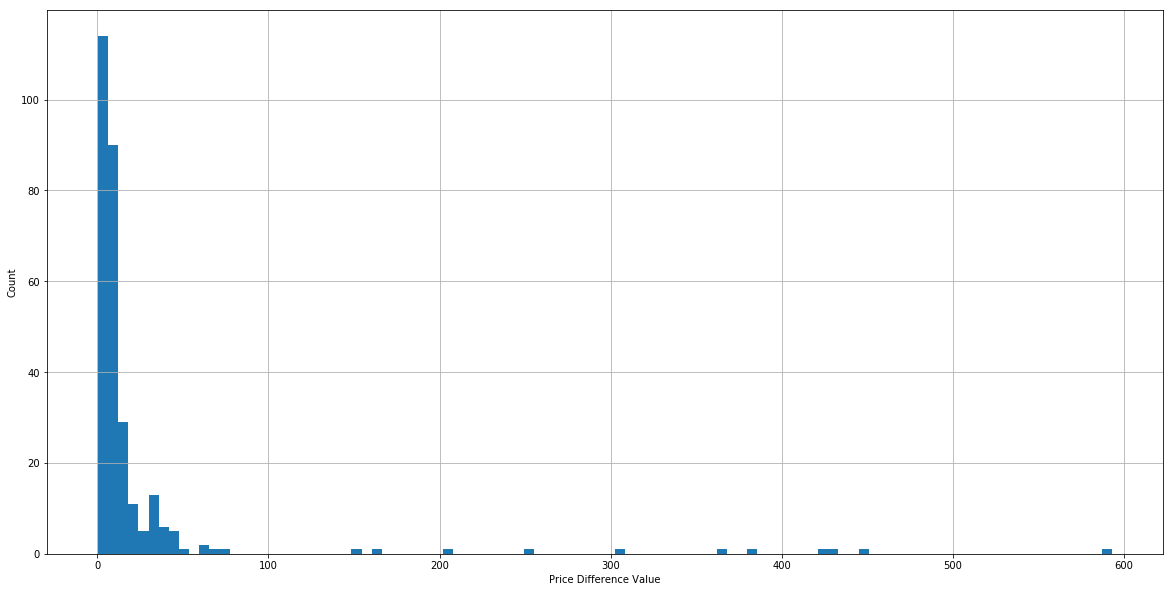

In [43]:
calls['Price_Difference'] = (calls['BSM_prices'] - calls['lastPrice']).abs()

plt.rcParams["figure.figsize"] = (20,10)
calls['Price_Difference'].hist(bins=100)
plt.xlabel('Price Difference Value')
plt.ylabel('Count');